# Convolutional Neural Networks - Transfer Learning

Training a Pre-trained CNN Classifier **VGG16** to classify images from the **CIFAR-10** database.

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import random_split

# convert data to a normalized torch.FloatTensor
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10('~/.pytorch', train=True, download=True, transform=normalize)
test_set = datasets.CIFAR10('~/.pytorch', train=False, download=True, transform=normalize)

# we split randomly 20% from the trainset into a validation set
train_set, validation_set = random_split(dataset, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(f'train_set: {len(train_set)} images')
print(f'validation_set: {len(validation_set)} images')
print(f'test_set: {len(test_set)} images')

train_set: 40000 images
validation_set: 10000 images
test_set: 10000 images


In [4]:
batch_size = 20

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [5]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Adjust VGG-16 Model

To define our model for training we:

1. Load in a **pre-trained VGG-16** model

2. **Freeze parameters**, so the net acts as a fixed feature extractor (the parameters in the pre-trained model will *not* change during training)

3. **Replace last layer** with a linear classifier of our own

In [6]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

# freeze training for all features-layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# replace last classifier-layer to outpur 10 classes
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
vgg16.classifier[6] = last_layer
vgg16.to(device)

summary(vgg16, input_size=(3, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

### Specify Loss Function and Optimizer

For the optimizer, we pass only the **parameter of the classifier** `vgg16.classifier.parameters()`, as these are the only onces we want to change during training.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.01)

## Train the adjusted VGG-16 Network

In [8]:
import time
start = time.time()

epochs = 2

validation_loss_min = np.Inf                     # track change in validation loss, we start with a loss of infinity

train_loss_history = []
validation_loss_history = []

for epoch in range(1, epochs + 1):

    train_loss = 0.0
    validation_loss = 0.0

    vgg16.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = vgg16(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch_size
        
    vgg16.eval()
    for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = vgg16(data)
        loss = criterion(output, target)
        validation_loss += loss.item() * batch_size
    
    # average losses for current epoch
    train_loss = train_loss / len(train_set)
    train_loss_history.append(train_loss)
    
    validation_loss = validation_loss / len(validation_set)
    validation_loss_history.append(validation_loss)
        
    # print training / validation statistics 
    print(f'Epoch: {epoch}\tTraining Loss: {train_loss:.6f} \tValidation Loss: {validation_loss:.6f}')
    
    # save model if validation loss has decreased
    if validation_loss <= validation_loss_min:
        print(f'Validation loss decreased. Saving model ...')
        torch.save(vgg16.state_dict(), 'vgg16_cifar.pt')
        validation_loss_min = validation_loss

end = time.time()
print(f'TRAIN TIME: {(end - start):.1f} sec')

Epoch: 1	Training Loss: 1.299651 	Validation Loss: 1.087413
Validation loss decreased. Saving model ...
Epoch: 2	Training Loss: 1.064642 	Validation Loss: 1.037664
Validation loss decreased. Saving model ...
TRAIN TIME: 5791.8 sec


###  Load the Model

In [19]:
vgg16.load_state_dict(torch.load('vgg16_cifar.pt'));

## Test the Trained Network

In [20]:
class_correct = list(0 for i in range(10))  # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
class_total = list(0 for i in range(10))

vgg16.eval()    # don't calculate gradients

for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = vgg16(data)
    _, pred = output.max(dim=1)
    correct_tensor = pred.eq(target)
    correct = correct_tensor.cpu().numpy() if device.type == 'cpu' else correct_tensor.numpy()

    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i]  # adds 1 if True, adds 0 if False
        class_total[label] += 1

# accuracy for each class
for i in range(len(classes)):
    if class_total[i] > 0:
        accuracy = class_correct[i] / class_total[i]
        print(f'Test Accuracy of {classes[i]:10} : {accuracy:.2%} [{class_correct[i]}/{class_total[i]}]')
    else:
        print(f'Test Accuracy of {classes[i]:10} : N/A (no training examples)')

# accuracy over all classes
accuracy = np.sum(class_correct) / np.sum(class_total)
print(f'Test Accuracy (Overall)     : {accuracy:.2%} [{np.sum(class_correct)}/{np.sum(class_total)}]')

Test Accuracy of airplane   : 67.90% [679/1000]
Test Accuracy of automobile : 82.30% [823/1000]
Test Accuracy of bird       : 51.70% [517/1000]
Test Accuracy of cat        : 53.70% [537/1000]
Test Accuracy of deer       : 49.00% [490/1000]
Test Accuracy of dog        : 54.60% [546/1000]
Test Accuracy of frog       : 79.20% [792/1000]
Test Accuracy of horse      : 65.60% [656/1000]
Test Accuracy of ship       : 75.20% [752/1000]
Test Accuracy of truck      : 58.10% [581/1000]
Test Accuracy (Overall)     : 63.73% [6373/10000]


### Visualize Test Images

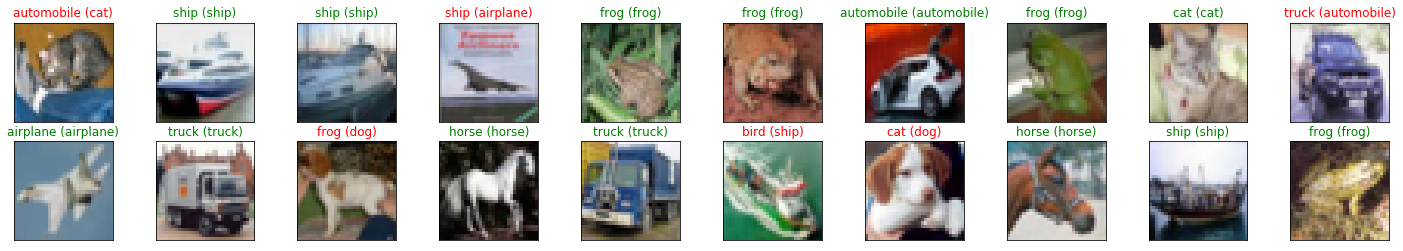

In [21]:
images, labels = next(iter(test_loader))  # one batch
if not device.type == 'cpu':
    images = images.cuda()

output = vgg16(images)
_, p = output.max(1)
preds = p.cpu().numpy() if device.type == 'cpu' else p.numpy()

def imshow(img):
    img = img / 2 + 0.5                           # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))      # convert from torch.Size([3, 32, 32]) to torch.Size([32, 32, 3])
    
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size / 2, idx + 1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title(f'{classes[preds[idx]]} ({classes[labels[idx]]})', color=('green' if preds[idx] == labels[idx].item() else 'red'))

# Classify Objects in Photographs using Pre-Trained Models

This script will demonstrate how to use a pre-trained models to make predictions.

## Download Image and Transform

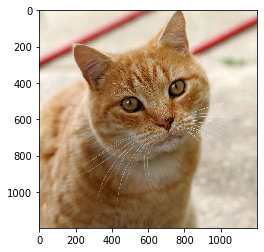

In [22]:
from torchvision import transforms
from PIL import Image
import io
import requests

response = requests.get('https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg')
image = Image.open(io.BytesIO(response.content))  # PIL image
plt.imshow(image);

In [23]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img = transform(image)
img.shape

torch.Size([3, 224, 224])

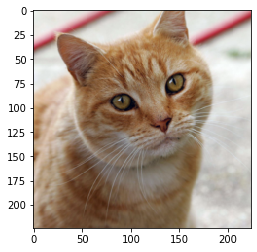

In [24]:
def imshow(img):
    img = (img - img.min()) / (img.max() - img.min())  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))           # convert from shape (3, 224, 224) to shape (224, 224, 3)

imshow(img)

## Model Inference

In [25]:
from torchvision import models
import torch

model = models.alexnet(pretrained=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [26]:
# get labels
response = requests.get('https://s3.amazonaws.com/outcome-blog/imagenet/labels.json')
labels = {int(key): value for key, value in response.json().items()}

input = img.unsqueeze(0)     # add a batch dimension

model.eval()
output = model(input)
predictions = torch.nn.functional.softmax(output, dim=1)

In [27]:
percent, idx = predictions.max(dim=1)
print(f"image shows a '{labels[idx.item()]}' with {percent.item():.1%} probability")

image shows a 'tiger cat' with 37.9% probability


In [28]:
percents, idxs = predictions.sort(descending=True)

for i in range(5):
    idx = idxs.squeeze(0)[i]
    percent = percents.squeeze(0)[i]
    print(f"image shows a '{labels[idx.item()]}' with {percent:.1%} probability")

image shows a 'tiger cat' with 37.9% probability
image shows a 'tabby, tabby cat' with 31.7% probability
image shows a 'Egyptian cat' with 23.6% probability
image shows a 'bow tie, bow-tie, bowtie' with 2.6% probability
image shows a 'lynx, catamount' with 2.1% probability
